In [1]:
import os
from rembg import remove
from PIL import Image
from tqdm import tqdm

# Paths
input_folder = "/home/prathamesh/Documents/IDC409_Project/dataset/train"   # original dataset
output_folder = "/home/prathamesh/Documents/IDC409_Project/dataset"  # background removed dataset in case the provided data was not perfect

# I create an output directory
os.makedirs(output_folder, exist_ok=True)

# Walk through subfolders within my parent directory (A little bit chatGPT and little manipulation of code)
for root, dirs, files in os.walk(input_folder):
    # Determine the relative subfolder path
    relative_path = os.path.relpath(root, input_folder)
    output_subfolder = os.path.join(output_folder, relative_path)
    os.makedirs(output_subfolder, exist_ok=True)

    for filename in tqdm(files, desc=f"Processing {relative_path}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_subfolder, filename)

            try:
                with Image.open(input_path) as img:
                    img_no_bg = remove(img)

                    # I Converted RGBA to RGB with black background to maintain consistency among the images
                    if img_no_bg.mode == 'RGBA':
                        background = Image.new("RGB", img_no_bg.size, (0, 0, 0))  # black background
                        background.paste(img_no_bg, mask=img_no_bg.split()[3])  # use alpha as mask
                        img_no_bg = background

                    # Save in the same format as original
                    img_no_bg.save(output_path, "JPEG" if filename.lower().endswith(('.jpg', '.jpeg')) else "PNG")

            except Exception as e:
                print(f" Error processing {filename}: {e}")

print(" Background removal complete. Images saved to:", output_folder)


Processing .: 0it [00:00, ?it/s]
Processing Magnifera_indica: 100%|████████████████████████████████████████████| 414/414 [04:38<00:00,  1.49it/s]

 Background removal complete. Images saved to: /home/prathamesh/Documents/IDC409_Project/dataset


In [3]:
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm

# Paths
input_base = "/home/prathamesh/Documents/IDC409_Project/dataset/BG_removed_1"
output_base = "/home/prathamesh/Documents/IDC409_Project/dataset/Augmented_1"
os.makedirs(output_base, exist_ok=True)

# Number of augmented images per original
AUG_MULTIPLIER = 25  # Now making 25 augmentations per image

# Augmentation function (learned from chatGPT and wrote it)
def augment_image(img):
    augmentations = []

    for _ in range(AUG_MULTIPLIER):
        aug = img.copy()

        # Random horizontal flip
        if random.random() > 0.5:
            aug = aug.transpose(Image.FLIP_LEFT_RIGHT)

        # Random rotation (-25 to 25 degrees for stronger variety)
        aug = aug.rotate(random.uniform(-25, 25), resample=Image.BICUBIC, expand=False)

        # Random zoom (crop and resize back)
        if random.random() > 0.5:
            zoom_factor = random.uniform(0.85, 1.0)  # 85% to 100% zoom
            w, h = aug.size
            new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
            left = random.randint(0, w - new_w)
            top = random.randint(0, h - new_h)
            aug = aug.crop((left, top, left + new_w, top + new_h))
            aug = aug.resize((w, h), Image.BICUBIC)

        # Random translation (shift)
        if random.random() > 0.5:
            w, h = aug.size
            max_shift = int(0.1 * w)  # up to 10% shift
            dx = random.randint(-max_shift, max_shift)
            dy = random.randint(-max_shift, max_shift)
            aug = aug.transform((w, h), Image.AFFINE, (1, 0, dx, 0, 1, dy))

        # Random brightness
        aug = ImageEnhance.Brightness(aug).enhance(random.uniform(0.8, 1.2))

        # Random contrast
        aug = ImageEnhance.Contrast(aug).enhance(random.uniform(0.8, 1.2))

        # Random color saturation
        aug = ImageEnhance.Color(aug).enhance(random.uniform(0.8, 1.2))

        # Random sharpness
        aug = ImageEnhance.Sharpness(aug).enhance(random.uniform(0.8, 1.5))

        augmentations.append(aug)

    return augmentations

# Loop through each class folder (chatGPT saved here, a lot of troubleshooting)
for class_name in os.listdir(input_base):
    class_input_path = os.path.join(input_base, class_name)
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_base, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    for filename in tqdm(os.listdir(class_input_path), desc=f"Augmenting {class_name}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(class_input_path, filename)

            with Image.open(input_path) as img:
                img = img.convert("RGB")  # Ensure RGB format

                # Save original
                img.save(os.path.join(class_output_path, filename), quality=95)

                # Generate augmentations
                for i, aug_img in enumerate(augment_image(img), start=1):
                    aug_filename = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
                    aug_img.save(os.path.join(class_output_path, aug_filename), quality=95)

print(" Augmentation done: 25 copies per original image with stronger variety")


Augmenting Magnifera_indica: 100%|████████████████████████████████████████████| 414/414 [00:29<00:00, 14.21it/s]

 Augmentation done: 25 copies per original image with stronger variety


In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Paths
input_base = "/home/prathamesh/Documents/IDC409_Project/dataset/Augmented_1"
output_base = "/home/prathamesh/Documents/IDC409_Project/dataset/Preprocessed_1"
os.makedirs(output_base, exist_ok=True)

# ImageNet normalization values
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(img):
    # Convert to LAB color space for CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB)

    # Bilateral filter to smooth without losing edges
    img = cv2.bilateralFilter(img, 9, 75, 75)

    # Convert to float and normalize (ImageNet)
    img = img.astype(np.float32) / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD

    return img

# Loop through dataset
for class_name in os.listdir(input_base):
    class_input_path = os.path.join(input_base, class_name)
    if not os.path.isdir(class_input_path):
        continue

    class_output_path = os.path.join(output_base, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    for filename in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_input_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            processed_img = preprocess_image(img)

            # Save as 8-bit JPG for storage (reverse normalization just for saving)
            save_img = ((processed_img * IMAGENET_STD) + IMAGENET_MEAN) * 255.0
            save_img = np.clip(save_img, 0, 255).astype(np.uint8)
            save_path = os.path.join(class_output_path, filename)
            cv2.imwrite(save_path, cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR))
            

print(" Preprocessing complete with CLAHE + Bilateral Filter + ImageNet normalization")


Processing Magnifera_indica: 100%|███████████████████████████████████████| 10764/10764 [01:06<00:00, 160.77it/s]

 Preprocessing complete with CLAHE + Bilateral Filter + ImageNet normalization


2025-08-28 15:50:28.970299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 15:50:28.970570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:50:29.007444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 15:50:29.905391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

TensorFlow version: 2.20.0
Num GPUs Available: 0


2025-08-28 15:50:30.878889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 36798 images belonging to 5 classes.
Found 9196 images belonging to 5 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/home/prathamesh/miniconda3/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 246s 213ms/step - accuracy: 0.8160 - loss: 0.5056 - val_accuracy: 0.8105 - val_loss: 0.4541
Epoch 2/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 240s 209ms/step - accuracy: 0.9292 - loss: 0.2089 - val_accuracy: 0.8581 - val_loss: 0.3945
Epoch 3/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 238s 207ms/step - accuracy: 0.9545 - loss: 0.1316 - val_accuracy: 0.8583 - val_loss: 0.4591
Epoch 4/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 239s 208ms/step - accuracy: 0.9697 - loss: 0.0873 - val_accuracy: 0.8506 - val_loss: 0.5696
Epoch 5/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 237s 206ms/step - accuracy: 0.9753 - loss: 0.0720 - val_accuracy: 0.8559 - val_loss: 0.5183
Epoch 6/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 237s 206ms/step - accuracy: 0.9795 - loss: 0.0599 - val_accuracy: 0.8409 - val_loss: 0.6627
Epoch 7/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 245s 213ms/step - accuracy: 0.9834 - loss: 0.0495 - val_accuracy: 0.8363 - val_loss: 0.8333
Epoch 8/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 247s 215ms/step - accuracy: 0.9

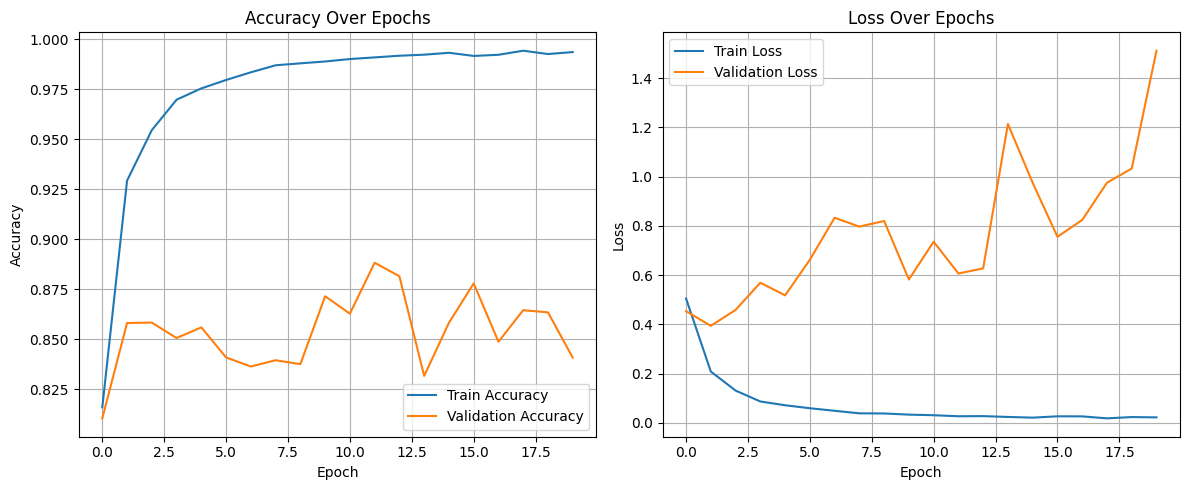

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


# PARAMETERS (EDA)

TRAIN_DIR = "/home/prathamesh/Documents/IDC409_Project/dataset/Preprocessed_1"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.2


# GPU / Metal Acceleration (Apple Silicon) (chatGPT suggested)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


# DATA LOADING (
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


# CNN MODEL

model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


# COMPILATION

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


# TRAINING

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


# SAVE MODEL in Dataset directory

os.makedirs("/home/prathamesh/Documents/IDC409_Project/dataset/models", exist_ok=True)
model.save("/home/prathamesh/Documents/IDC409_Project/dataset/models/leaf_cnn_model.keras")
print("Model saved as dataset/models/leaf_cnn_model.keras")

# PLOT TRAINING vs VALIDATION METRICS 

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step


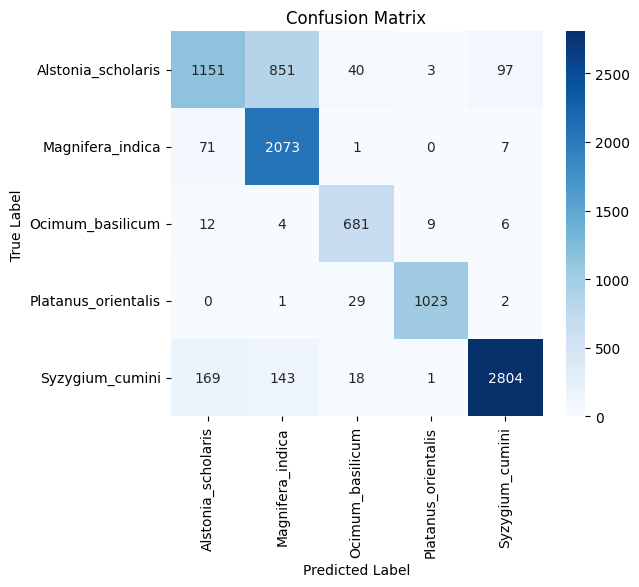


Classification Report:

                     precision    recall  f1-score   support

 Alstonia_scholaris       0.82      0.54      0.65      2142
   Magnifera_indica       0.67      0.96      0.79      2152
   Ocimum_basilicum       0.89      0.96      0.92       712
Platanus_orientalis       0.99      0.97      0.98      1055
    Syzygium_cumini       0.96      0.89      0.93      3135

           accuracy                           0.84      9196
          macro avg       0.87      0.86      0.85      9196
       weighted avg       0.86      0.84      0.84      9196



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


# CONFUSION MATRIX & REPORT (took forever to understand --> chatGPT, Perplexity, literature,...)


# True labels from the validation generator 
y_true = val_generator.classes

# Predictions
y_pred_prob = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)  # For categorical classes

# Safety check: Ensure lengths match
if len(y_pred) != len(y_true):
    print(f"Length mismatch detected: y_true={len(y_true)}, y_pred={len(y_pred)}")
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [7]:
from tensorflow.keras.models import load_model

# Load the trained CNN model
model_path = "/home/prathamesh/Documents/IDC409_Project/dataset/models/leaf_cnn_model.keras"
model = load_model(model_path)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/home/prathamesh/Documents/IDC409_Project/dataset/Preprocessed_1"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VALIDATION_SPLIT
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 9196 images belonging to 5 classes.


In [9]:
import numpy as np

y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

/home/prathamesh/miniconda3/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step


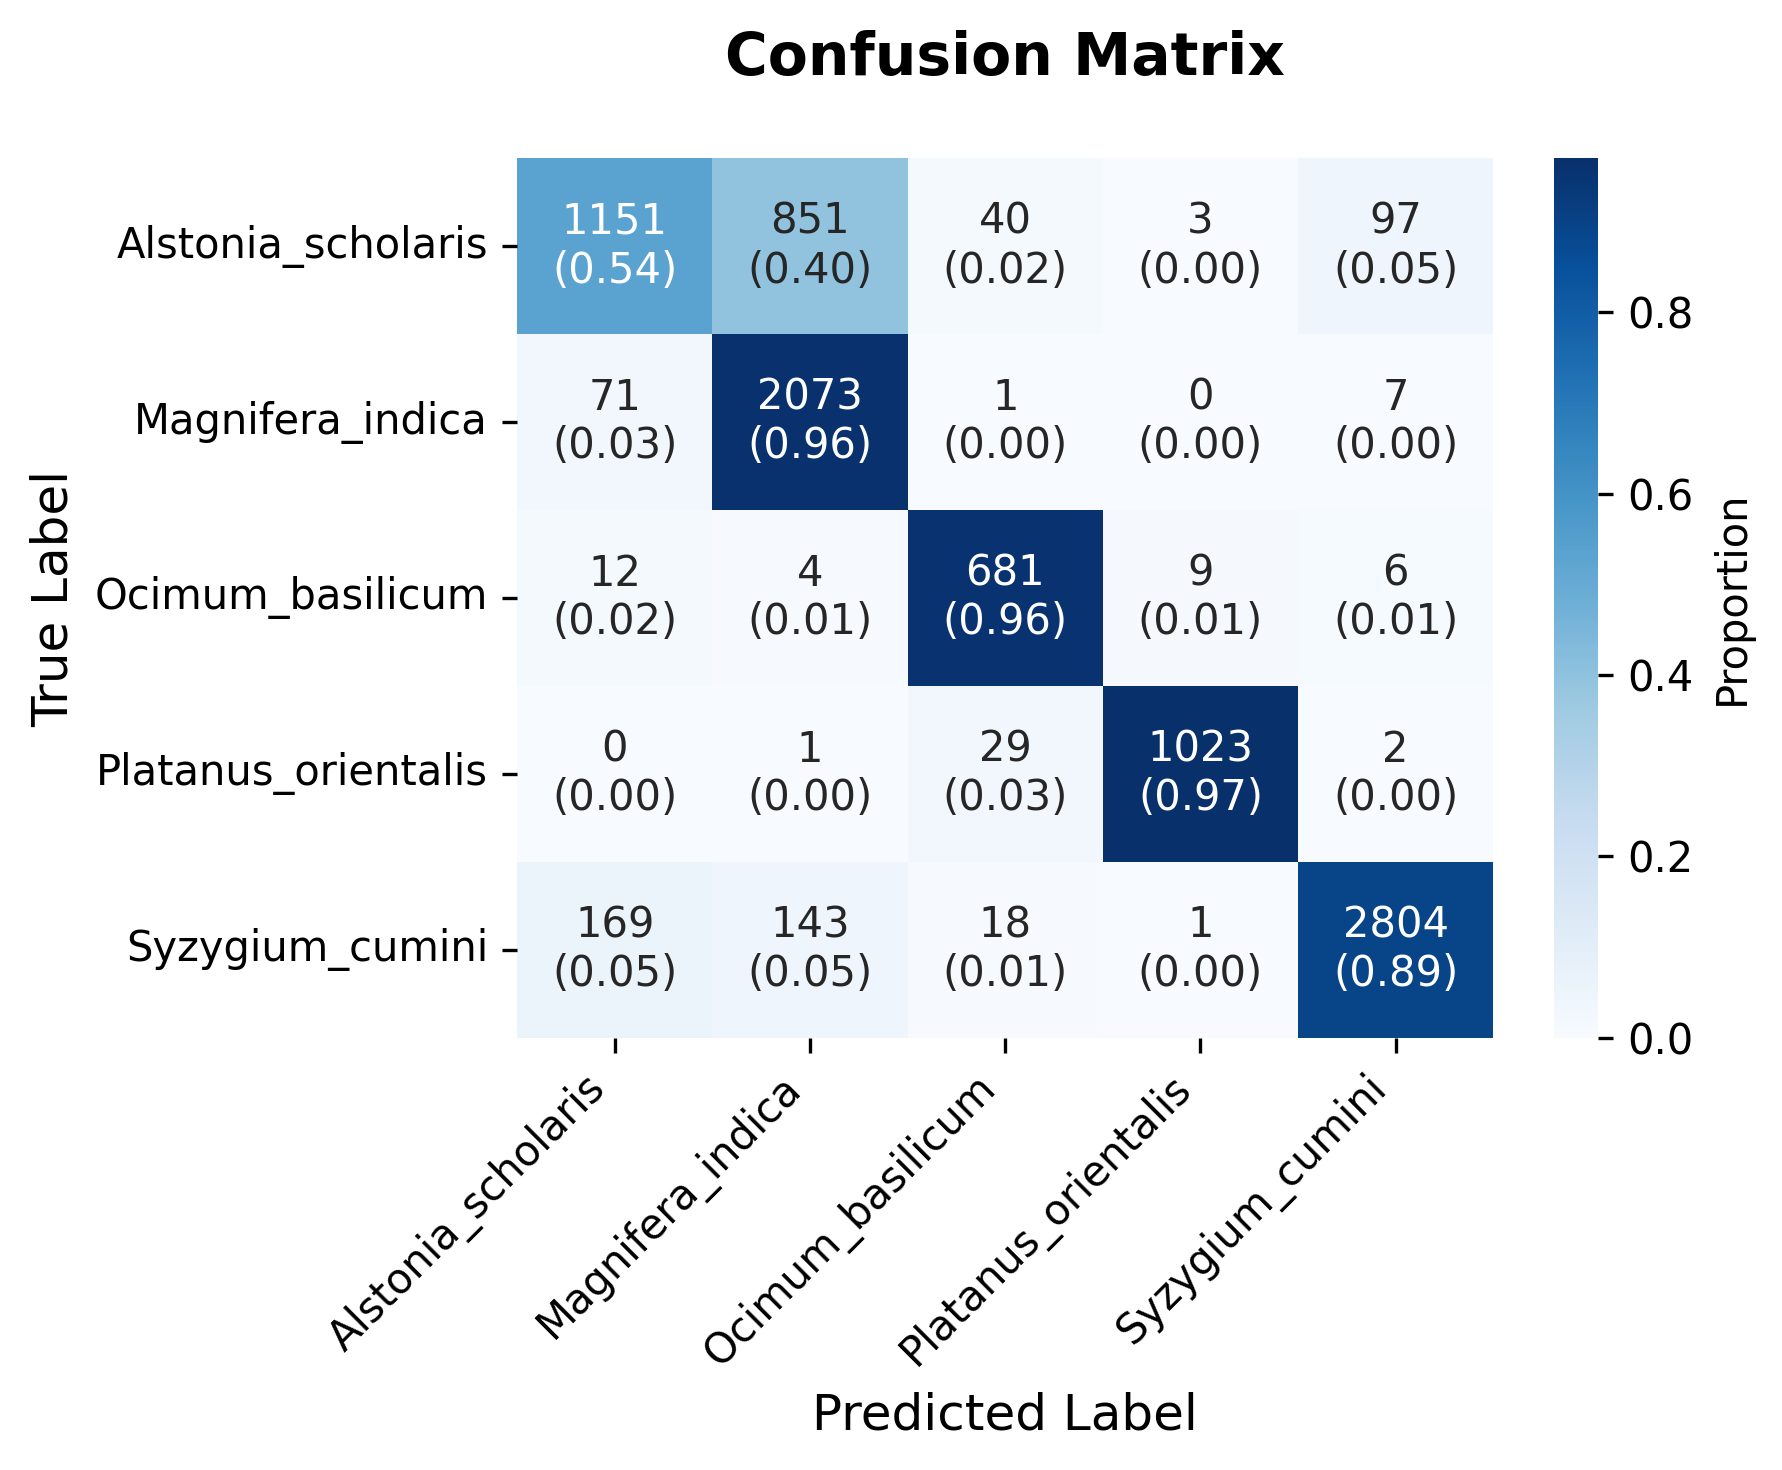

Classification Report:

                     precision    recall  f1-score   support

 Alstonia_scholaris     0.8204    0.5373    0.6494      2142
   Magnifera_indica     0.6748    0.9633    0.7936      2152
   Ocimum_basilicum     0.8856    0.9565    0.9196       712
Platanus_orientalis     0.9875    0.9697    0.9785      1055
    Syzygium_cumini     0.9616    0.8944    0.9268      3135

           accuracy                         0.8408      9196
          macro avg     0.8660    0.8642    0.8536      9196
       weighted avg     0.8587    0.8408    0.8364      9196



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

# Normalize for proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Combine counts and proportions in annotations
annot_labels = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_labels[i, j] = f"{cm[i, j]}\n({cm_normalized[i, j]:.2f})"

# Plot confusion matrix
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(
    cm_normalized,
    annot=annot_labels,
    fmt='',
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'label': 'Proportion'}
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Added spacing with pad
plt.title("Confusion Matrix", fontsize=14, weight='bold', pad=20)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("Classification Report:\n")
print(report)


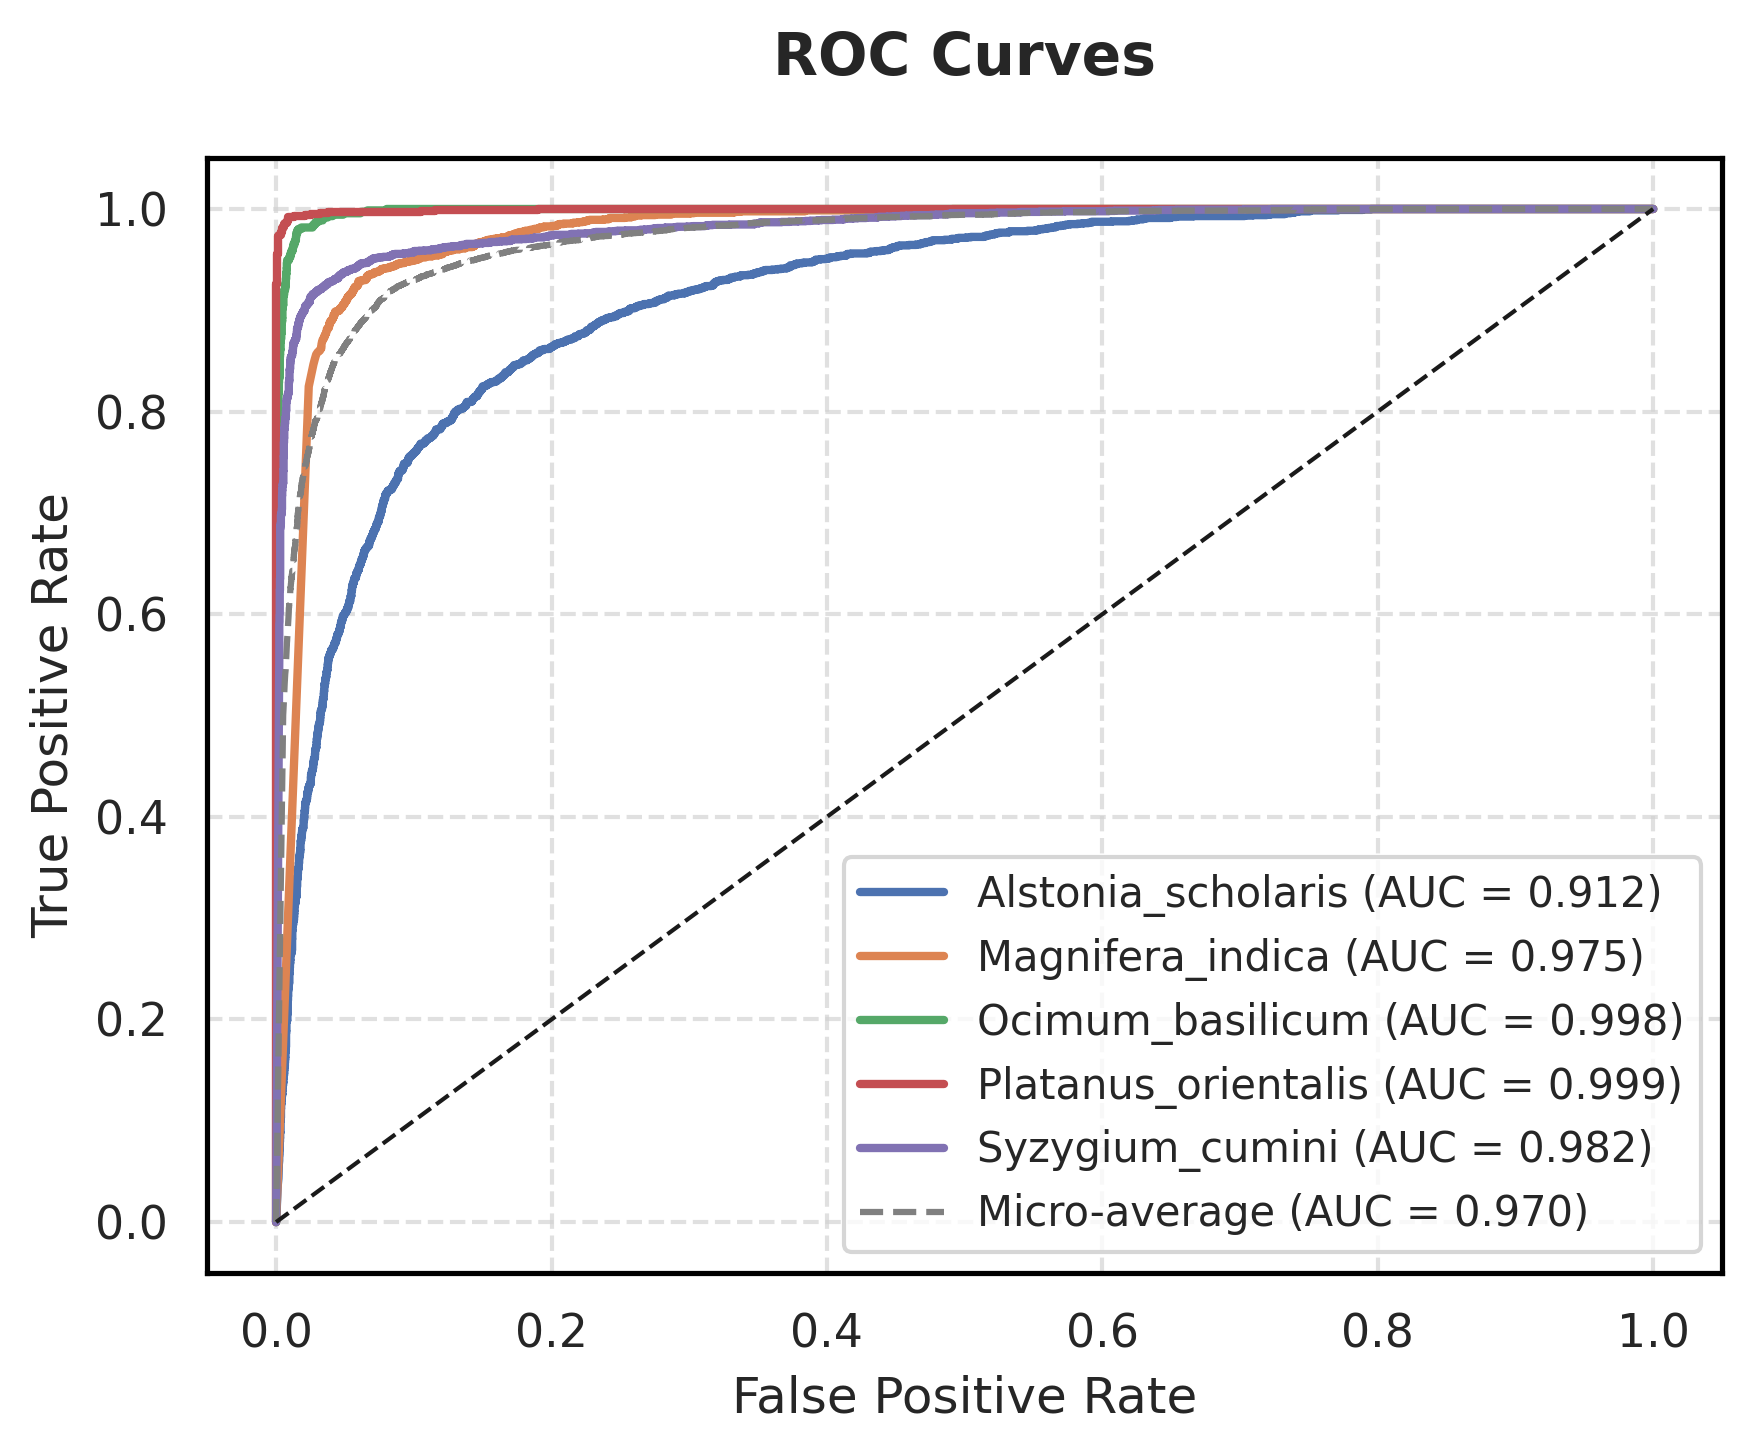

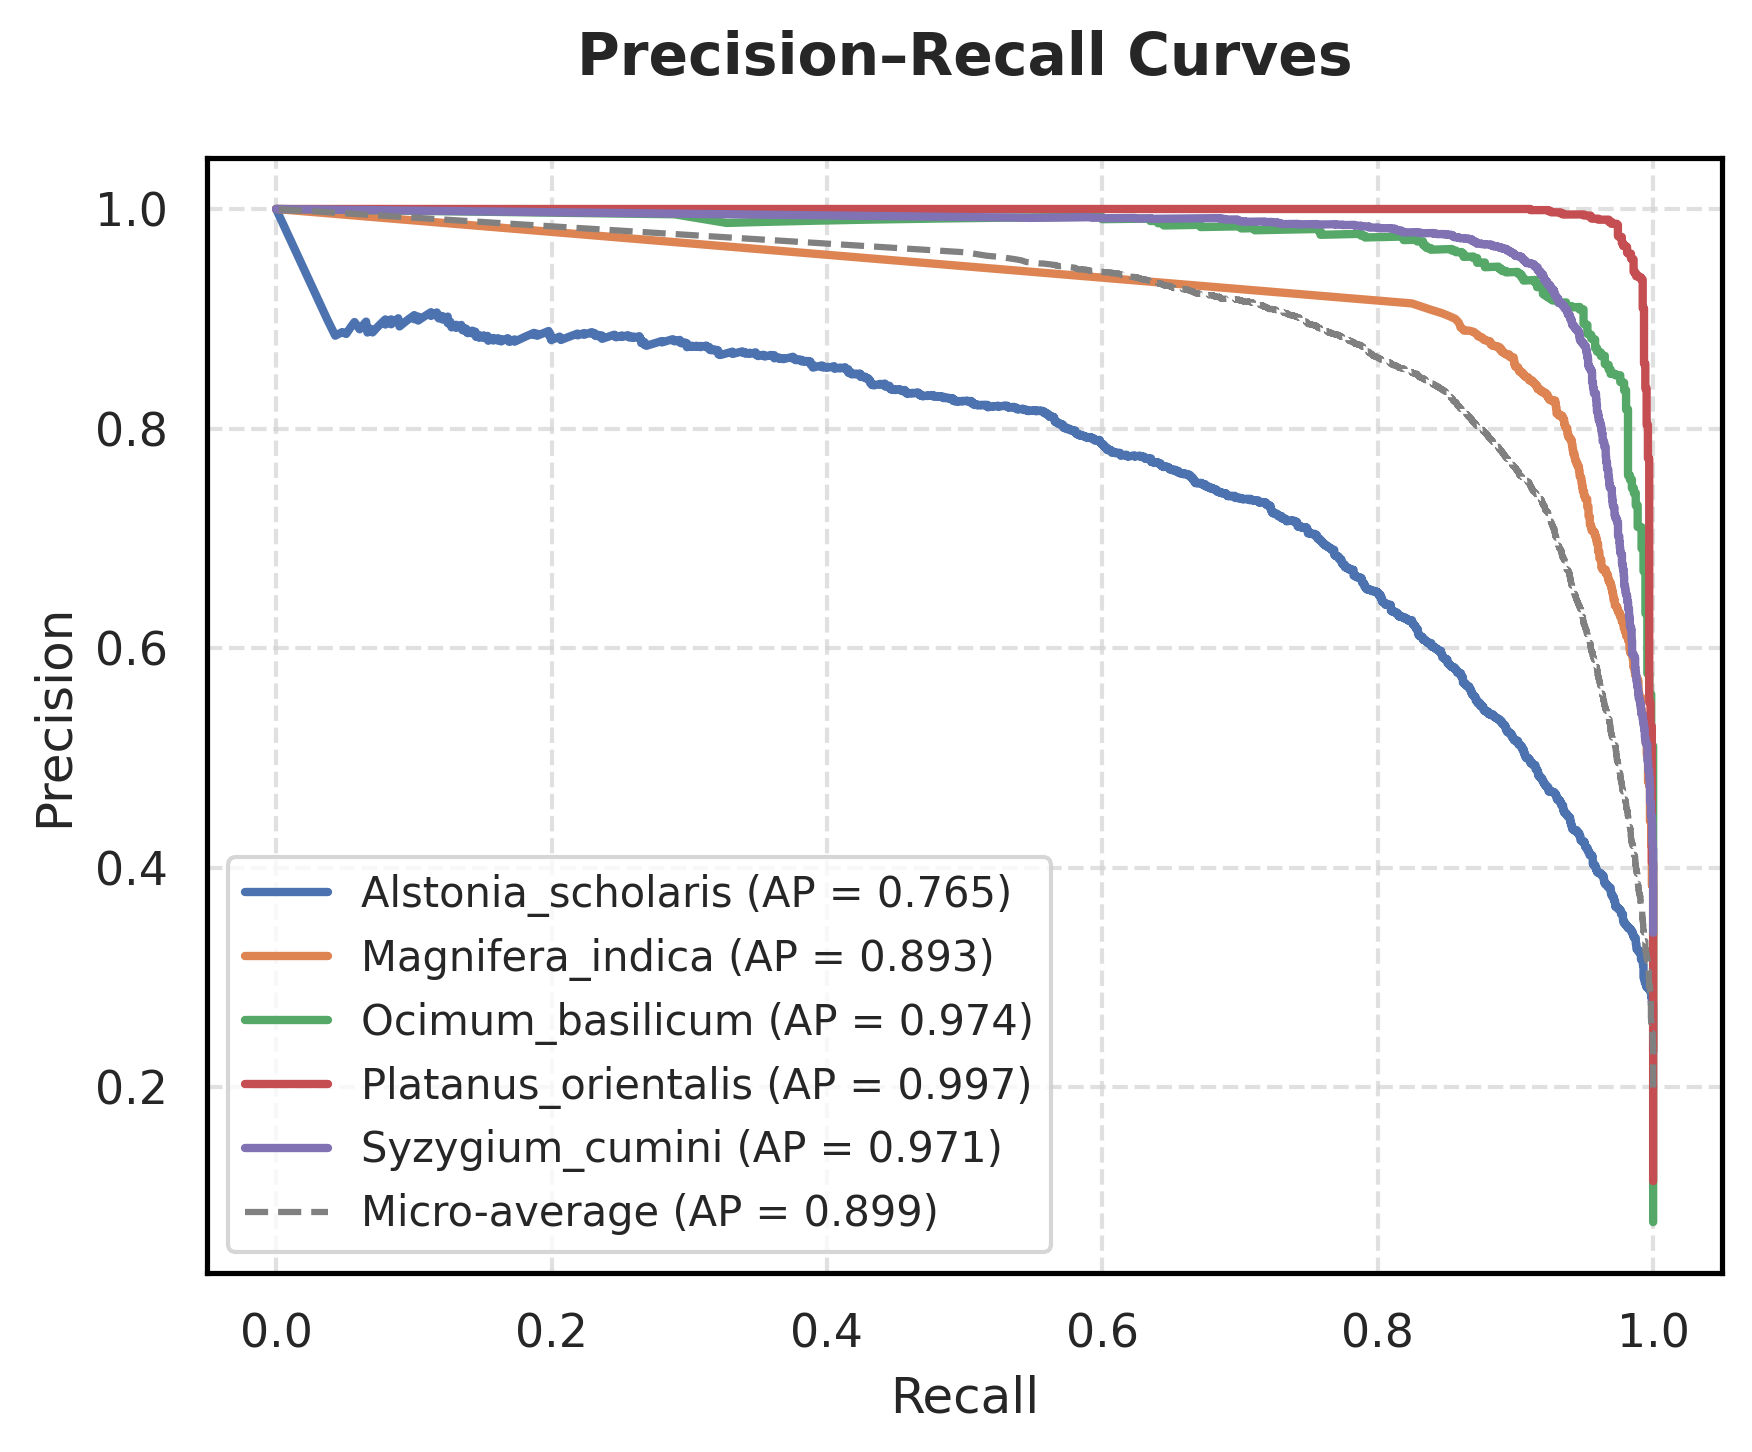

Cohen's Kappa: 0.7902
Matthews Correlation Coefficient: 0.7992
Balanced Accuracy: 0.8642
Alstonia_scholaris - Sensitivity: 0.5373, Specificity: 0.9643
Magnifera_indica - Sensitivity: 0.9633, Specificity: 0.8582
Ocimum_basilicum - Sensitivity: 0.9565, Specificity: 0.9896
Platanus_orientalis - Sensitivity: 0.9697, Specificity: 0.9984
Syzygium_cumini - Sensitivity: 0.8944, Specificity: 0.9815


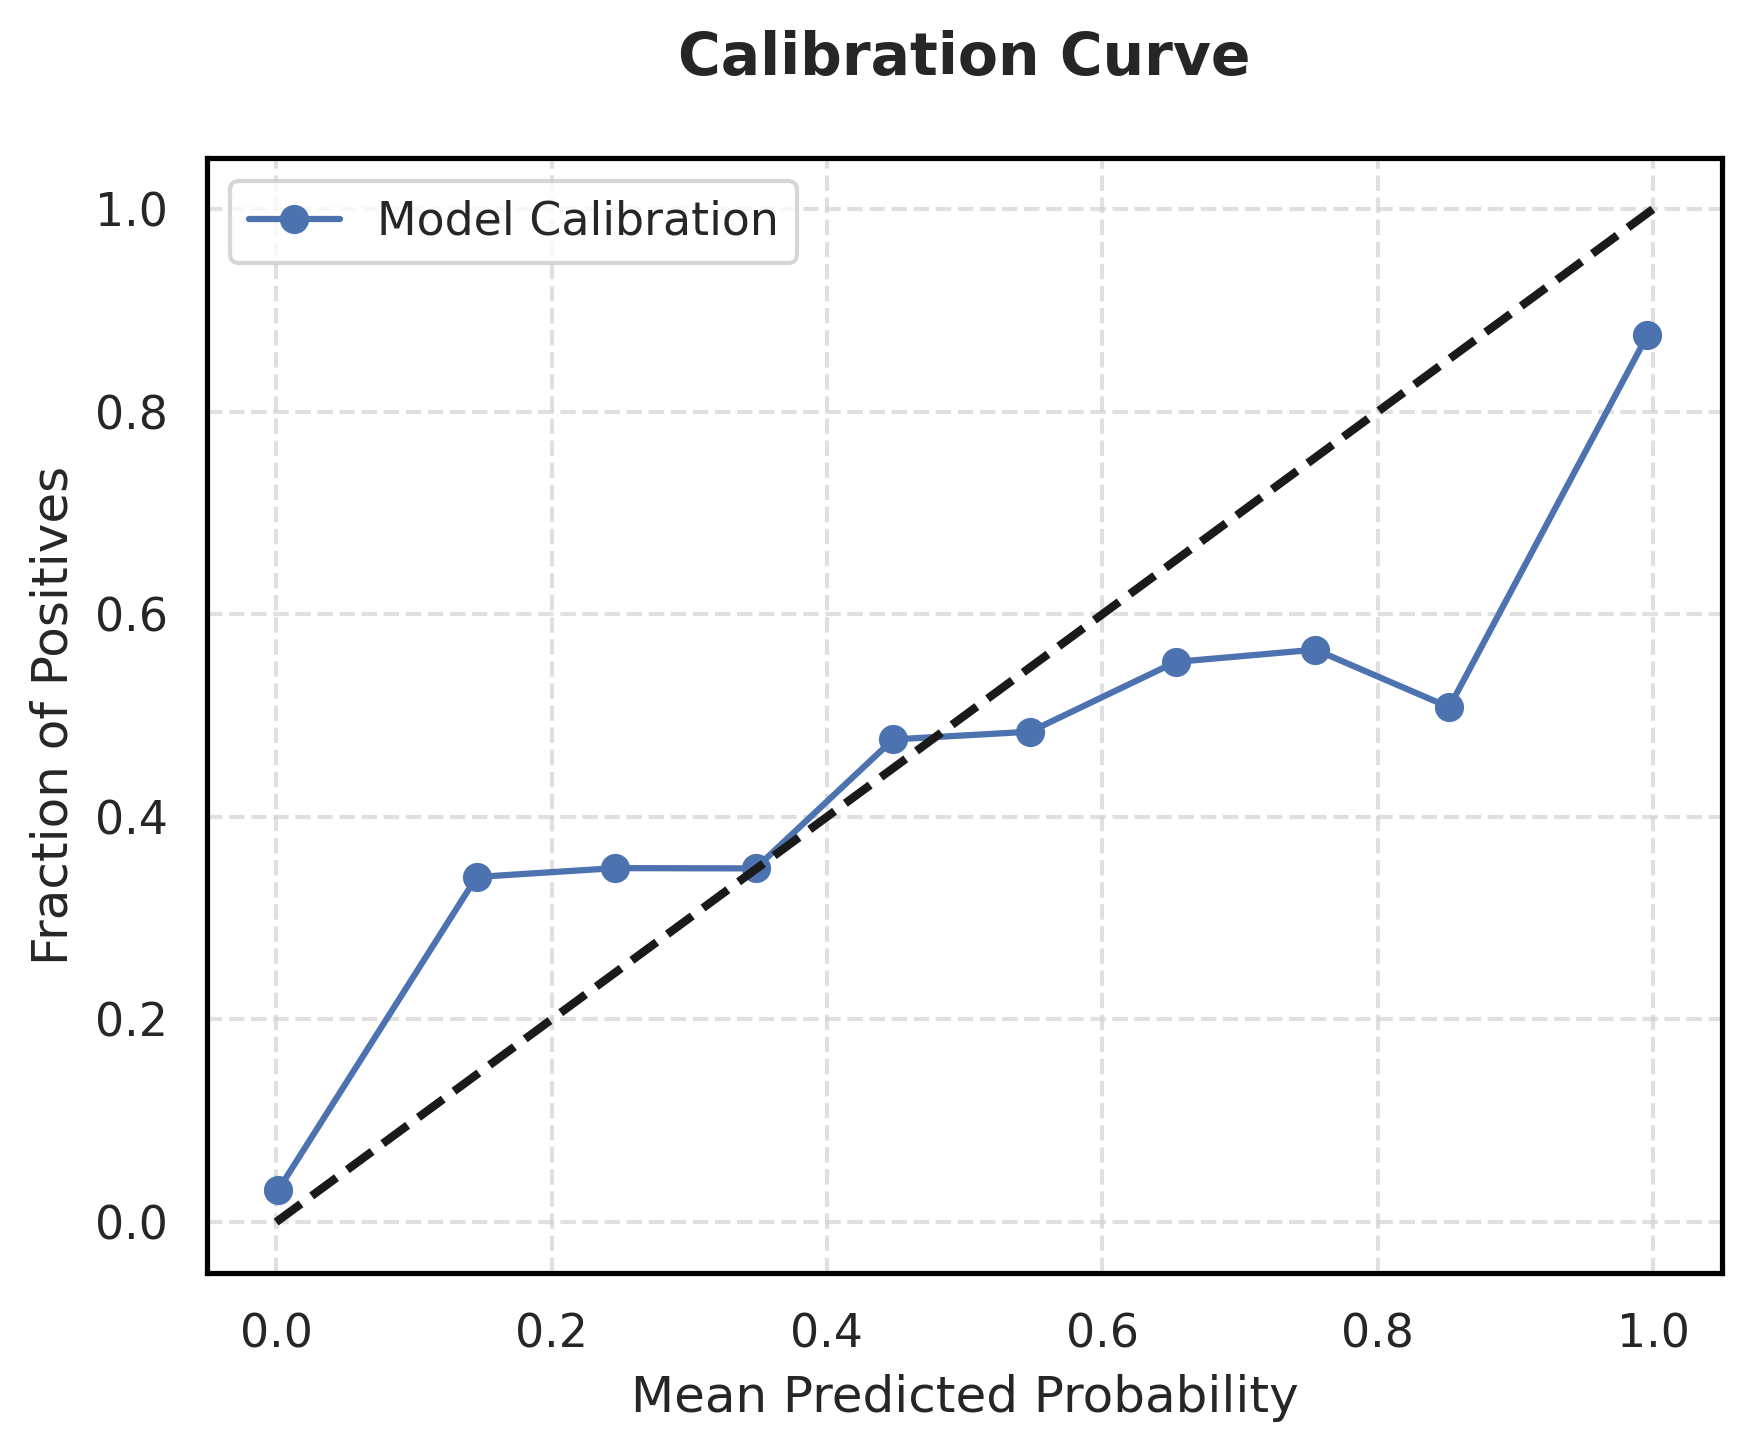

Number of misclassified samples: 1464 out of 9196 total


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")  # or "white", "darkgrid", etc.
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",  # ensures no seaborn gray background
    "axes.edgecolor": "black",
    "axes.grid": True,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.alpha": 0.7,
    "figure.dpi": 300
})

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score, cohen_kappa_score,
    matthews_corrcoef, balanced_accuracy_score
)
from sklearn.calibration import calibration_curve
import tensorflow as tf



# ROC Curves & AUC

n_classes = len(class_labels)
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(6, 5), dpi=300)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{class_labels[i]} (AUC = {roc_auc:.3f})")

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', color='gray', label=f"Micro-average (AUC = {roc_auc_micro:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves', fontsize=14, weight='bold', pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Precision–Recall Curves

plt.figure(figsize=(6, 5), dpi=300)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, linewidth=2, label=f"{class_labels[i]} (AP = {ap_score:.3f})")

# Micro-average PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())
ap_micro = average_precision_score(y_true_bin, y_pred_prob, average="micro")
plt.plot(recall_micro, precision_micro, linestyle='--', color='gray', label=f"Micro-average (AP = {ap_micro:.3f})")

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curves', fontsize=14, weight='bold', pad=20)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# Additional Metrics

kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)

print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")


# Class-wise Sensitivity & Specificity

sensitivities = cm.diagonal() / cm.sum(axis=1)  # Recall per class
specificities = []
for i in range(len(class_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificities.append(tn / (tn + fp))

for idx, label in enumerate(class_labels):
    print(f"{label} - Sensitivity: {sensitivities[idx]:.4f}, Specificity: {specificities[idx]:.4f}")


# Calibration Curve

prob_true, prob_pred = calibration_curve(y_true_bin.ravel(), y_pred_prob.ravel(), n_bins=10)
plt.figure(figsize=(6, 5), dpi=300)
plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("Mean Predicted Probability", fontsize=12)
plt.ylabel("Fraction of Positives", fontsize=12)
plt.title("Calibration Curve", fontsize=14, weight='bold', pad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Misclassification Summary

misclassified_idx = np.where(y_true != y_pred)[0]
print(f"Number of misclassified samples: {len(misclassified_idx)} out of {len(y_true)} total")
